In [ ]:
#import 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf


In [ ]:
#load data 
df= pd.read_csv('/content/stock_data.csv',low_memory=False,
                 parse_dates=["Date"],index_col="Date")

In [ ]:
# chỉ sử dụng cổ phiếu của TSLA
data = df[df['Stock']=='TSLA'].copy()
data.sort_index() # sắp xếp theo index
data.head(10)

,Open,High,Low,Close,Volume,OpenInt,Stock
Date,,,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0,0,TSLA
2010-06-29,19.00,25.00,17.54,23.89,18783276,0,TSLA
2010-06-30,25.79,30.42,23.30,23.83,17194394,0,TSLA
2010-07-01,25.00,25.92,20.27,21.96,8229863,0,TSLA
2010-07-02,23.00,23.10,18.71,19.20,5141807,0,TSLA
2010-07-06,20.00,20.00,15.83,16.11,6879296,0,TSLA
2010-07-07,16.40,16.63,14.98,15.80,6924914,0,TSLA
2010-07-08,16.14,17.52,15.57,17.46,7719539,0,TSLA
2010-07-09,17.58,17.90,16.55,17.40,4058606,0,TSLA


In [ ]:
#check Na values
data.isna().sum()

Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Stock      0
dtype: int64

In [ ]:
# xem info của data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1858 entries, 2010-06-28 to 2017-11-10
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1858 non-null   float64
 1   High     1858 non-null   float64
 2   Low      1858 non-null   float64
 3   Close    1858 non-null   float64
 4   Volume   1858 non-null   int64  
 5   OpenInt  1858 non-null   int64  
 6   Stock    1858 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 116.1+ KB


In [ ]:
# không dùng 3 cột này 
data.drop(columns=['OpenInt','Volume','Stock'],axis=1,inplace =True)

In [ ]:
scaler = MinMaxScaler()
X=data.drop("Close",axis=1)
y=data['Close']

In [ ]:
X=scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [ ]:
# hàm đánh giá mô hình
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Test MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Test RMSLE": rmsle(y_test, test_preds),
              "Training R^2": model.score(X_train, y_train),
              "Test R^2": model.score(X_test, y_test)}
    return scores

In [ ]:
# dùng gridsearch cho SVR
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr = SVR()
svr_model = GridSearchCV(svr, parameters, cv=5,
                              verbose=True)
svr_model.fit(X_train,y_train)

In [ ]:
svr_model.best_params_

In [ ]:
svr_pred=svr_model.predict(X_test)
svr_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': svr_pred})
svr_pred_df.head()

,Actual,Predicted
Date,,
2016-05-24,217.91,216.608491
2016-05-25,219.58,218.403426
2016-05-26,225.12,221.450828
2016-05-27,223.04,223.511223
2016-05-31,223.23,222.837909


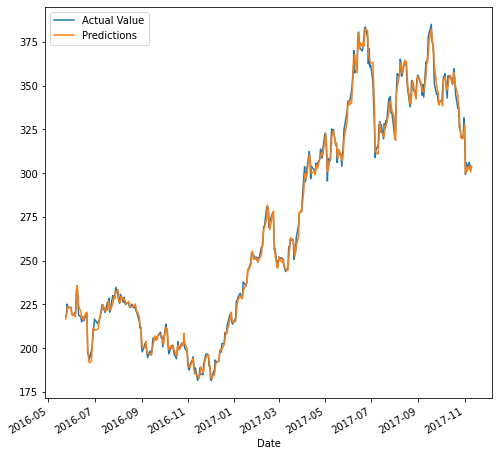

In [ ]:
plt.figure(figsize=(8,8))
svr_pred_df['Actual'].plot()
svr_pred_df['Predicted'].plot()
plt.legend(['Actual Value', 'Predictions'])

In [ ]:
show_scores(svr_model)

{'Test MAE': 2.581232148649025,
 'Test RMSLE': 0.012119431317346718,
 'Test R^2': 0.9969372192996562,
 'Training MAE': 1.4458757820772756,
 'Training RMSLE': 0.02021013007546908,
 'Training R^2': 0.9993894850198153}

In [ ]:
rf_grid = {"n_estimators": np.arange(10, 50, 10),
           "max_depth": [ 3, 5, 10],
           "min_samples_split": np.arange(2, 5, 2),
           "min_samples_leaf": np.arange(1, 5, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [100,200,300]}
rs_model = GridSearchCV(RandomForestRegressor(),rf_grid,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train,y_train)

In [ ]:
rs_model.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'max_samples': 300,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

In [ ]:
y_RF_pred= rs_model.predict(X_test)
pred_RF_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_RF_pred})
pred_RF_df.head()

,Actual,Predicted
Date,,
2016-05-24,217.91,218.045358
2016-05-25,219.58,218.485917
2016-05-26,225.12,221.104167
2016-05-27,223.04,221.575667
2016-05-31,223.23,222.640500


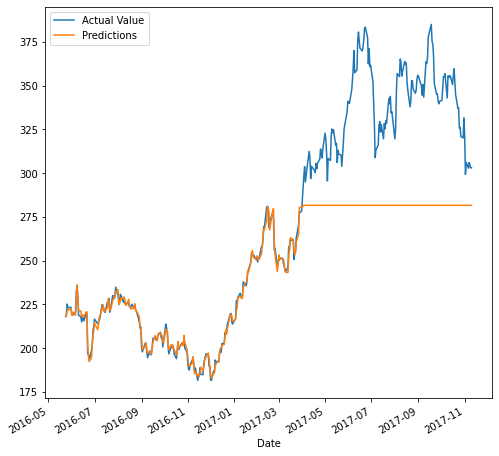

In [ ]:
plt.figure(figsize=(8,8))
pred_RF_df['Actual'].plot()
pred_RF_df['Predicted'].plot()
plt.legend(['Actual Value', 'Predictions'])

In [ ]:
show_scores(rs_model)

{'Test MAE': 24.436174238351278,
 'Test RMSLE': 0.12423978682596828,
 'Test R^2': 0.5994952587843064,
 'Training MAE': 1.0665463220942357,
 'Training RMSLE': 0.015540818052597022,
 'Training R^2': 0.999676470656345}

In [ ]:
# dùng cột close để train cho LSTM
data_close=y.copy()
data_close.head()

Date
2010-06-28    17.00
2010-06-29    23.89
2010-06-30    23.83
2010-07-01    21.96
2010-07-02    19.20
Name: Close, dtype: float64

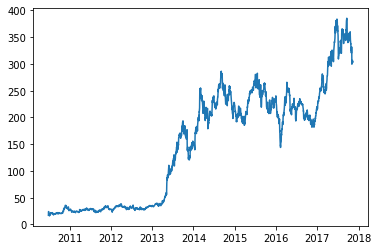

In [ ]:
plt.plot(data_close)
plt.show()

In [ ]:
time_step = 30 # window = 30, dùng dữ liệu của 30 ngày trước để dự đoán giá trị hiện tại
X_cl, y_cl = [], []

for i in range(len(data_close)-time_step):
    X_cl.append(data_close[i:(i+time_step)])
    y_cl.append(data_close[(i+time_step)])

X_cl = np.array(X_cl)
y_cl = np.array(y_cl)

In [ ]:
X_cl = scaler.fit_transform(X_cl)
pd.DataFrame(X_cl).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.003250,0.021912,0.021750,0.016685,0.009209,0.000840,0.000000,0.001114,0.000951,0.000000,0.001470,0.006097,0.006233,0.008274,0.011731,0.007349,0.007131,0.009254,0.010044,0.009118,0.008029,0.008492,0.007485,0.006369,0.009036,0.011840,0.009962,0.007757,0.005416,0.005444
1,0.021912,0.021750,0.016685,0.009209,0.000840,0.000000,0.004496,0.000951,0.000000,0.002962,0.006097,0.006233,0.008274,0.011731,0.007349,0.007131,0.009254,0.010044,0.009118,0.008029,0.008492,0.007485,0.006369,0.009036,0.011840,0.009962,0.007757,0.005416,0.005444,0.003892
2,0.021750,0.016685,0.009209,0.000840,0.000000,0.004496,0.004334,0.000000,0.002962,0.007583,0.006233,0.008274,0.011731,0.007349,0.007131,0.009254,0.010044,0.009118,0.008029,0.008492,0.007485,0.006369,0.009036,0.011840,0.009962,0.007757,0.005416,0.005444,0.003892,0.000817
3,0.016685,0.009209,0.000840,0.000000,0.004496,0.004334,0.003386,0.002962,0.007583,0.007718,0.008274,0.011731,0.007349,0.007131,0.009254,0.010044,0.009118,0.008029,0.008492,0.007485,0.006369,0.009036,0.011840,0.009962,0.007757,0.005416,0.005444,0.003892,0.000817,0.000000
4,0.009209,0.000840,0.000000,0.004496,0.004334,0.003386,0.006338,0.007583,0.007718,0.009757,0.011731,0.007349,0.007131,0.009254,0.010044,0.009118,0.008029,0.008492,0.007485,0.006369,0.009036,0.011840,0.009962,0.007757,0.005416,0.005444,0.003892,0.000817,0.000000,0.001960


In [ ]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size = 0.2, shuffle=False)
Acc = []

In [ ]:
X_train_ = X_cl_train.reshape(X_cl_train.shape[0],X_cl_train.shape[1],1)

X_test_ = X_cl_test.reshape(X_cl_test.shape[0],X_cl_test.shape[1],1)

In [ ]:
X_train_.shape

(1462, 30, 1)

In [ ]:
def Reg():
    model = Sequential()
    model.add(LSTM(70, return_sequences=True,activation='relu', input_shape=(30,1)))
    model.add(LSTM(70, return_sequences=False,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [ ]:
model_1 = Reg()
model_1.fit(X_train_, y_cl_train, epochs=100, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 10s 166ms/step - loss: 15948.2588 - val_loss: 51782.7422
Epoch 2/100
37/37 [==============================] - 6s 157ms/step - loss: 15214.1963 - val_loss: 22107.3711
Epoch 3/100
37/37 [==============================] - 6s 157ms/step - loss: 4658.9878 - val_loss: 1515.2769
Epoch 4/100
37/37 [==============================] - 6s 154ms/step - loss: 501.7724 - val_loss: 923.4481
Epoch 5/100
37/37 [==============================] - 6s 158ms/step - loss: 306.9231 - val_loss: 727.8214
Epoch 6/100
37/37 [==============================] - 6s 155ms/step - loss: 286.8908 - val_loss: 958.1299
Epoch 7/100
37/37 [==============================] - 6s 155ms/step - loss: 265.5087 - val_loss: 728.6225
Epoch 8/100
37/37 [==============================] - 6s 153ms/step - loss: 270.0977 - val_loss: 730.6518
Epoch 9/100
37/37 [==============================] - 6s 156ms/step - loss: 274.0042 - val_loss: 803.9799
Epoch 10/100
37/37 [========================

In [ ]:
y_pred_lstm = model_1.predict(X_test_)

In [ ]:
pred_df = pd.DataFrame({'Actual': y_cl_test, 'Predicted': y_pred_lstm.flatten()})
pred_df.head()

,Actual,Predicted
0,218.96,223.049500
1,218.99,224.448837
2,220.68,226.137680
3,232.34,227.058807
4,235.52,226.811325


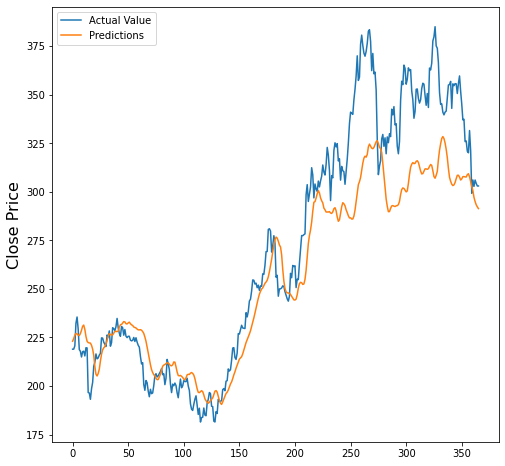

In [ ]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [ ]:
import pickle
from keras.models import load_model
# Save an existing model to file
pickle.dump(svr_model, open("svr_model.pkl", "wb"))
pickle.dump(rs_model,open("RF_model.pkl","wb"))
#model_1.save("LSTM_model_1.h5")

In [ ]:
# Load a saved model
load_svr_model = pickle.load(open("svr_model.pkl", "rb"))
load_rf_model=pickle.load(open("RF_model.pkl","rb"))
#model_1.load_model("LSTM_model.h5")

In [ ]:
def demo():  
  input_data=[]
  open=float(input("nhap gia tri open: "))
  input_data.append(open)
  high=float(input("nhap gia tri high: "))
  input_data.append(high)
  low=float(input("nhap gia tri low: "))
  input_data.append(low)

  input_data=np.asarray(input_data)
  input_data=input_data.reshape(1,3)
  pred2=svr_model.predict(input_data)
  pred3=rs_model.predict(input_data)
  
  print("gia tri close du doan cua mo hinh SVR:",pred2)
  print("gia tri close du doan cua mo hinh RF:",pred3)
  print("gia tri close thuc te:",y_test[1:2])
  print(" ")
  # print("mo hinh LSTM voi timestep=30 can nhap 30 gia tri")
  # input_data1=[]
  # for i in range (30):
  #   close=float(input("nhap gia tri close: "))
  #   input_data1.append(close)
  # input_data1=np.asarray(input_data1)
  # input_data1=input_data1.reshape(1,30)
  # pred1=model_1.predict(input_data1)
  # print("gia tri close du doan cua mo hinh LSTM:",pred1.flatten())
  print("gia tri close thuc te:",y_test[31])

In [ ]:
y_test[0:30]

In [ ]:
y_test[31]

216.78

In [ ]:
X_test[1:2]

array([[0.54451491, 0.54890343, 0.56146399]])

In [ ]:
demo()

nhap gia tri open: 21
nhap gia tri high: 25
nhap gia tri low: 23
gia tri close du doan cua mo hinh SVR: [8627.38631533]
gia tri close du doan cua mo hinh RF: [281.5695]
gia tri close thuc te: Date
2016-05-25    219.58
Name: Close, dtype: float64
 
mo hinh LSTM voi timestep=30 can nhap 30 gia tri
nhap gia tri close: 23
nhap gia tri close: 25
nhap gia tri close: 24
nhap gia tri close: 12
nhap gia tri close: 26
nhap gia tri close: 24
nhap gia tri close: 28
nhap gia tri close: 29
nhap gia tri close: 287
nhap gia tri close: 27
nhap gia tri close: 28
nhap gia tri close: 29
nhap gia tri close: 24
nhap gia tri close: 26
nhap gia tri close: 28
nhap gia tri close: 22
nhap gia tri close: 24
nhap gia tri close: 6
nhap gia tri close: 27
nhap gia tri close: 28
nhap gia tri close: 24
nhap gia tri close: 26
nhap gia tri close: 23
nhap gia tri close: 24
nhap gia tri close: 24
nhap gia tri close: 21
nhap gia tri close: 25
nhap gia tri close: 26
nhap gia tri close: 22
nhap gia tri close: 22
gia tri close